# Sentiment analysis of COVID19 and BlackLivesMatter related tweets 
This code allows us to study the polarity of tweets associated with multiple trends at different timepoints. The objective is to determine how certain social events can trigger a change in the sentiment of the Twitter community. <p>

This code allows to perform:
* **Data extraction:** Retrieve tweets associated with a certain topic and timepoint. 
* **Preprocessing:** Remove tweets not belonging to the query search criteria or repeated tweets.
* **Sentiment Analysis:** Determine the polarity of the tweets.
* **Data selection:** Combine different datasets and select samples to obtain comparable results. 
* **Exploratory Analysis:** Perform an exploratory analysis of the data. 
* **One-class SVM:** Compare the trends at two different time points to identify the most distinct samples. 

As an example of the we will compare tweets from two currently viral trends the #BlackLivesMatter movement and the #COVID19 pandemic. Both datasets will be studied at two different time points, before and after the George Floyd's death. To observe how such a significant and politicised event affected the polarity of both trends. As a control a dataset expected to be independent of the event will be used, which includes tweets associated with pets, containing the #kitten and #pet.

## 1. Import all packages <p>
***WARNING***: Before trying to load the packages make sure they are installed in the python environment you are working with. Most packages can be installed using the `pip install` command (packages: numpy, csv, re, os, matplotlib, pandas). For installing the rest follow the instructions described in: <p>
- [GetOldTweets3] (https://pypi.org/project/GetOldTweets3/)
- [VaderSentimentAnalysis] (https://github.com/cjhutto/vaderSentiment)
- [sklearn] (https://github.com/scikit-learn/scikit-learn)


In [4]:
# Load packages
import GetOldTweets3 as got
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
import os
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.svm import OneClassSVM

## 2. Retrieve tweets with a certain hashtag 
To extract historical tweets from Twitter the package GetOldTweets was used. The query search has to be run directly from in terminal using the following lines of code. This will search for all the tweets that can be found based on the search criteria specified and it will save the tweet and some related information in a csv file. The specifications in the search criteria will be: <p>

- **`querysearch`:** The word used for the query search. In this case several hashtags will be used. <br>
- **`since` & `until`:** Allow to set the timeframe in which the tweets will be retrieved. <br>
- **`toptweets`:** Only stores tweets regarded by Twitter as Top tweets, usually they have more favourites, replies and retweets.<br>
- **`lang`:** Filters the language of the tweets retrieved. **en**: English <br>
- **`output`:** Determines the name of the output file in which the tweets are stored. <p>

In this example, the tweets are queried based on a hashtag associated to their trend: #BlackLivesMatter, #COVID19, #kitten, #pet. The query list will be limited to 6 days for both time points. The time points will be located before and after the murder of George Floyd (25 May 2020).

**10-15th May 2020** <br>
* `GetOldTweets3 --querysearch "#BlackLivesMatter" --since "2020-05-10" --until "2020-05-15" --toptweets --maxtweets 10000 --lang en --output "BLM10M.csv"`<br>
* `GetOldTweets3 --querysearch "#COVID19" --since "2020-05-10" --until "2020-05-15" --toptweets --maxtweets 10000 --lang en --output "COVID10M.csv"`<br>
* `GetOldTweets3 --querysearch "#kitten" --since "2020-05-10" --until "2020-05-15" --toptweets --maxtweets 10000 --lang en --output "kitten10M.csv"` <br>
* `GetOldTweets3 --querysearch "#pet" --since "2020-05-10" --until "2020-05-15" --toptweets --maxtweets 10000 --lang en --output "pet10M.csv"` <br>

**26- 31 May 2020** <br>
* `GetOldTweets3 --querysearch "#BlackLivesMatter" --since "2020-05-26" --until "2020-05-31" --toptweets --maxtweets 10000 --lang en --output "BLM26M.csv"`<br>
* `GetOldTweets3 --querysearch "#kitten" --since "2020-05-26" --until "2020-05-31" --toptweets --maxtweets 10000 --lang en --output "kitten26M.csv"`<br>
* `GetOldTweets3 --querysearch "#pet" --since "2020-05-26" --until "2020-05-31" --toptweets --maxtweets 10000 --lang en --output "pet26M.csv" `<br>
* `GetOldTweets3 --querysearch "#COVID19" --since "2020-05-26" --until "2020-05-31" --toptweets --maxtweets 10000 --lang en --output "COVID26M.csv" `<p>

To increase reproducibility, the exact files used for the example are also provided with this code. Therefore it is not necessary to run the GetOldTweets3 query for the example analysis.  <br>

## 3. Load data from .csv files 

The data extracted in the previous step has to be reloaded for its analysis. It is also possible to load .csv files not extracted with the GetOldTweets3 package. Nevertheless, make sure they contain the same structure as the [tweet class](https://pypi.org/project/GetOldTweets3/) created by GetOldTweets3. <p> 
**INSTRUCTIONS:** Introduce the name of each .csv file to load in one element of the `namefiles` list and run this block of code. <p> 

Each csv file will be stored as a new entry in the data_all dictionary. The key name will be the name of the .csv file and the value associated to the key will contain a list of lists storing all the variables retrieved for each tweet sample. 

**NOTE:** Make sure that the .csv files are located in the same folder as the .ipnyb main file and the names are written exactly in the same way as the file to load (with no extra spaces at the start or the end of the string). ***WARNING: Case sensitive!***

In [5]:
#Replace elements in the list by the name of the .csv files to load
namefiles = ['BLM10M', 'BLM26M', 
            'COVID10M', 'COVID26M', 
            'kitten10M', 'kitten26M', 
            'pet10M', 'pet26M']

# Load all csv files
all_data = {}

for dataset in namefiles:
    with open(dataset + '.csv', newline='') as f:
        reader = csv.reader(f)
        list_reader = list(reader)
        all_data[dataset] = list_reader

## 4. Preprocessing 
This step filters the data loaded to ensure its quality. It will check that there are no obvious outliers, samples that are not of interest or repeated tweets. All these elements have to be removed as they could bias the analysis and the conclusions extracted from it. The specific preprocessing steps performed are:<p> 

**1. Date check:** GetOldTweets3 sometimes includes tweets that do not meet the desired date criteria. The code checks if all tweets are from May 2020 (2020-05) as both timepoints tested lay within this month. Samples with the 'date' variable not starting with 2020-05 will be removed from all datasets. <p>

**2. Hashtag check:** Validates if the hashtag of interest is present in the text of the tweet. It tries to prevent unrelated tweets from being included in the analysis. Theoretically, the query search should only provide tweets with the hashtag of interest but GetOldTweets3 sometimes includes unrelated messages. These can be filtered out with this step. <p>

**3. Duplicate check:** Checks if there are repeated tweets. *** WARNING:*** This step filters the tweets by URL not by text. This ensures that only real duplicates (exact copies for all variables) are filtered and preserves tweets sharing the same text but that were posted by different users or by the same user at different dates. 

**INSTRUCTIONS:** Replace the hashtag list with the hashtag associated with each key in the all_data dictionary. The list hashtag must be of the same size as the number of dataframes to test. If multiple dataframes use the same hashtag they must be repeated. After running the preprocessing code two dictionaries are obtained. 
- Filtered data: for each dataset it stores a dataframe containing the variables for all samples. *It will be used for further stages of the analysis*
- Removed_data: for each dataset stores the samples discarded by the preprocessing phase. *For informative purposes only*

**NOTE:** After running the code an overview of the number of samples removed will be provided. The preprocessing phase will always remove at least 1 sample from each dataframe as it corresponds to the first row from the list, which contains the labels of the columns. 

In [6]:
# %% PREPROCESSING : 

all_data_removed = {}
filtered_data = {}

# List of the hashtags used in each dataset
hashtag = [
           '#BlackLivesMatter', '#BlackLivesMatter',
           '#COVID19', '#COVID19', 
           '#kitten', '#kitten', 
           '#pet', '#pet'
          ]

length_datasets = []

# Preprocessing loop
for i, datas in enumerate(all_data):
    # Transform data to dataframe
    prep_data = pd.DataFrame(all_data[datas])

    # Check if data is from in May of 2020
    may_check = prep_data[0].str.contains('2020-05')
    filtered_data[datas] = prep_data[may_check]
    removed_data = prep_data[~may_check]

    # Check data contains the # of interest (CASE INSENSITIVE)
    hashtag_check = filtered_data[datas][6].str.contains(hashtag[i], flags=re.IGNORECASE)
    filtered_data[datas] = filtered_data[datas][hashtag_check]
    removed_data.append(filtered_data[datas][~hashtag_check])

    # Check repeated tweets (using URL)
    equal_check = filtered_data[datas][11].duplicated()
    filtered_data[datas] = filtered_data[datas][~equal_check]
    removed_data.append(filtered_data[datas][equal_check])
    
    # Save removed samples in dictionary
    all_data_removed[datas] = removed_data

    # Display info on number of samples removed
    count_removed = len(removed_data)
    print('Original size of data ' + datas + ': ' + str(len(prep_data)))
    print('New size of data ' + datas + ': ' + str(len(filtered_data                                                                                 [datas])))


Original size of data BLM10M: 313
New size of data BLM10M: 303
Original size of data BLM26M: 10001
New size of data BLM26M: 9966
Original size of data COVID10M: 10001
New size of data COVID10M: 10000
Original size of data COVID26M: 10001
New size of data COVID26M: 10000
Original size of data kitten10M: 163
New size of data kitten10M: 159
Original size of data kitten26M: 186
New size of data kitten26M: 179
Original size of data pet10M: 213
New size of data pet10M: 212
Original size of data pet26M: 220
New size of data pet26M: 219


## 5.Sentiment Analysis
This step analyses the polarity of the tweets stored in `filtered_data` using the Vader sentiment analyser package. In general, the analyser ranks the words on the tweet based on their "sentiment" and computes an overal score between 0 and 1 for three different variables: positive, neutral and negative. These scores can be combined in an overal compound score (between -1 and 1) which reflects the general polarity of the tweet. Tweets with a score close to -1 are regarded as highly negative while tweets close to 1 are regarded as highly positive. Tweets at 0 or very close to it will be interpreted as neutral.

**INSTRUCTIONS:** The sentiment analysis code processes each tweet individually. Therefore it can take some time to run. For the example dataset the expected run time is around: 15s but larger datasets can take even longer. A message will be displayed indicating the sentiment analysis is complete once it is done. <p>

The output of the sentiment analysis is a dictionary (`scores_all`) with the same information than filtered_data but including the four sentiment scores (neg, neu, pos & compound). 

In [7]:
#%% SENTIMENT ANALYSIS: Identify how positive, negative or neutral is a tweet. 

analyzer = SentimentIntensityAnalyzer()
# Perform sentiment analysis for each dataset
scores_all = {}
for i, datas in enumerate (filtered_data): # For each dataset
    selected = filtered_data[datas]
    scores = []
    row_names = selected.index.values # Save original sample ids
    
    # Check sentiment of each sentence
    for ind, sentence in enumerate(selected[6]): 
        vs = analyzer.polarity_scores(sentence) # Obtain sentiment scores
        # Add scores to the previous data
        scores.append([sentence, selected[3][row_names[ind]], 
                      selected[4][row_names[ind]], selected[5][row_names[ind]], 
                      vs['neg'], vs['neu'], vs['pos'], vs['compound']])

    # Save all info as a dataframe maintaining the original labels (for traceability) 
    scores_all[datas] = pd.DataFrame(scores, columns=['Text', 'reply', 'rts', 
                                                      'fav', 'neg', 'neu', 
                                                      'pos', 'compound'])

    scores_all[datas].index = list(row_names) # Assign saved labels to new dataframe
    
    # Add a marker to differentiate samples in the control set (as they will be merged)
    if (datas == 'kitten10M') or (datas == 'kitten26M'): 
        scores_all[datas].index = list ('k'+ scores_all[datas].index.astype(str))

print('Sentiment analysis completed.')

Sentiment analysis completed.


## 6. Check validity of control data
As mentioned before, in this project the control dataset will be built combining the data from two different queries (pet and kitten datasets). This is done to ensure that the sample size of the control dataset is comparable with the other datsets. Before merging both datasets it is necessary to check if they are homogeneous in terms of mean compound score and variance. This is done using boxplots. 

**NOTE**: If both samples show very different mean compound score or variance it is not recommended to merge both datasets as it could significantly affect the results obtained. 

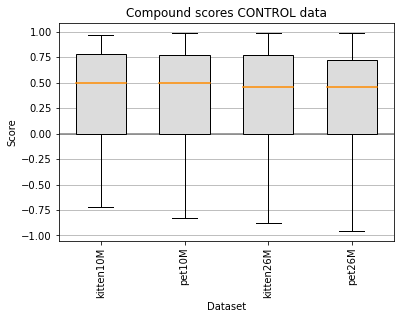

In [8]:

def variable_boxplot(variable, title, label):
    # Plot boxplots from a single variable. 
    # INPUTS: 
    #   variable: list containing all the samples to plot.
    #   title: String containing the title of the plot.
    #   labels: Labels assigned to each box in the boxplot.
    
    _, ax = plt.subplots()
    ax.axhline(y = 0,linewidth=1.5,color='grey')
    plt.boxplot(variable, labels=label,
                patch_artist=True, widths= 0.6,
                medianprops=dict(color='darkorange',linewidth=1.5),
                boxprops=dict(facecolor='gainsboro', color='k'))
    
    plt.title(title)
    ax.yaxis.grid(True)
    plt.xticks(rotation=90)
    plt.xlabel('Dataset')
    plt.ylabel('Score')
    plt.show()

control_keys = ['kitten10M', 'pet10M', 'kitten26M', 'pet26M']

compound_control = []
# Merge scores of all datasets
for val in control_keys:
    compound_control.append(scores_all[val]['compound'])

# Check if controls are equal 
title= 'Compound scores CONTROL data'
variable_boxplot(compound_control, title, control_keys)

## 7. Merge datasets
Both datasets will be combined in a dataset, under the key named `control`. To ensure it is possible to trace back the original dataset of each sample, the IDs for the samples comming from kitten dataset were modified to include a k. <p>
A boxplot will be displayed after merging the datasets to explore the median and variance of the final `control` dataset.

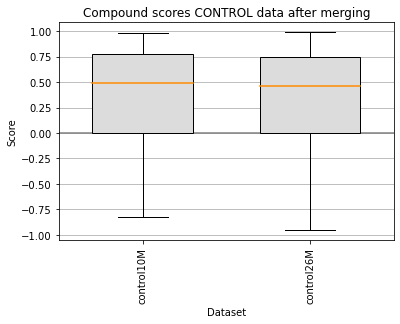

In [9]:
scores_all['control10M'] = pd.concat([scores_all['kitten10M'], scores_all['pet10M']])
scores_all['control26M'] = pd.concat([scores_all['kitten26M'], scores_all['pet26M']])

# Delete old keys (now merged in control 10M and control26M)
del scores_all['kitten10M'], scores_all['kitten26M']
del scores_all['pet10M'], scores_all['pet26M']

# Plot merged data 
label=['control10M', 'control26M']
title= 'Compound scores CONTROL data after merging'
variable_boxplot([scores_all['control10M']['compound'], 
                  scores_all['control26M']['compound']], title,label) 

## 8. Test resampling
`BLM26M`, `COVID10M` and `COVID26M` have  10.000 samples while `BLM10M` and both `control` groups have around 300 samples. To do a proper analysis the sample-size must be comparable across different classes. Therefore, downsampling of the large groups must be performed to match it with the smallest dataset. This downsampling will be performed by selecting a random subset of samples from all the datasets larger than the smallest one. 

To check how different random saplings could affect the analysis we will test how the mean `compound` score changes across multiple sampling iterations. This will be visualized in a boxplot.

**INSTRUCTIONS:** Select the number of iterations by changing the variable `num_resamp`. More iterations will provide more significant results but will imply longer computation time. 

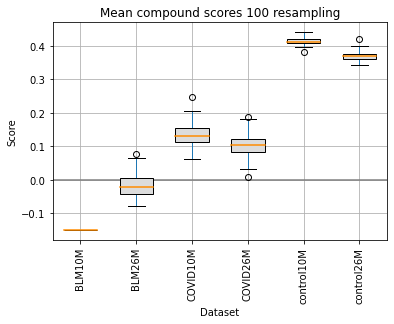

In [10]:
#%% TEST RESAMPLING
# Test if the downsmpling performed is representative of the whole population. 

num_resamp = 100

length_datasets = []
#Find sizes of datasets 
for datas in scores_all:
    length_datasets.append(len(scores_all[datas]))  

# Find smallest dataset
min_sample = min(length_datasets) 

sampled_data = {}
av_repeated = {}

# Repeat resampling multiple times (num_resamp)
for resamp in range (num_resamp):
    save_comp_mean = []
    for data in scores_all:   
        sampled_data[data] =  scores_all[data].sample(min_sample) 
        save_comp_mean.append(np.mean(sampled_data[data]['compound']))
    av_repeated[resamp] = save_comp_mean

av_repeated = pd.DataFrame(av_repeated).transpose() #necessary for boxplot
av_repeated.columns = list(sampled_data.keys())

fig, ax = plt.subplots()
ax.axhline(y = 0, linewidth=1.5, color='grey')
av_repeated.boxplot(patch_artist=True, widths= 0.6,
                medianprops=dict(color='darkorange',linewidth=1.5),
                boxprops=dict(facecolor='gainsboro', color='k'))
plt.xlabel('Dataset')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Mean compound scores ' + str(num_resamp) + ' resampling')
plt.show()

## 9. Data sampling
To ensure the reproducibility of the analysis, all the following steps of the analysis will use the downsampling performed using a constant seed. 

**INSTRUCTIONS:** The following code provides as an output the `sampled_data` dictionary containing for each dataset the selected samples and all the variables linked to them. To ease the following steps of the analysis (see step 10) the variables reply, rts and fav were converted to numeric values. 

In [11]:
#%% DATA SAMPLING: Select a random subset of data (constant seed)

length_datasets = []
# Find sizes of datasets 
for datas in scores_all:
    length_datasets.append(len(scores_all[datas])) 

# Find smallest dataset
min_sample = min(length_datasets) 
sampled_data = {}

# Select a random subset of samples of size of the dataset with less samples.
# NOTE: The variables 'reply','rts' and 'fav' are being converted to numeric values for further analysis. 
for data in scores_all:  
    sampled_data[data] = scores_all[data].sample(min_sample, random_state=1) 
    sampled_data[data]['reply'] = pd.to_numeric(sampled_data[data]['reply'])
    sampled_data[data]['rts'] = pd.to_numeric(sampled_data[data]['rts'])
    sampled_data[data]['fav'] = pd.to_numeric(sampled_data[data]['fav'])
print('Sampling completed.')

Sampling completed.


## 10. Data inspection
This exploratory analysis alows to observe the different variables of all datasets. From this code: 2 different sets of boxplots are provided. <p>
**1. Individual plots for each dataset:** Represent the results of the sentiment analysis for each dataset individually. They display an overview of the negative, neutral and positive scores. <p>
**1. Variable plots:** Allow to explore how a single variable changes across the different datasets. The code is prepared to obtain variable plots for any the numerical variables in `sampled_data`. In this code only the plots for: `compound score`, `rts`, `fav` and `reply` are shown. Similar plots can be obtained using the variables `save_neg`, `save_pos` or `save_neu` as the input for the variable_boxplot function.

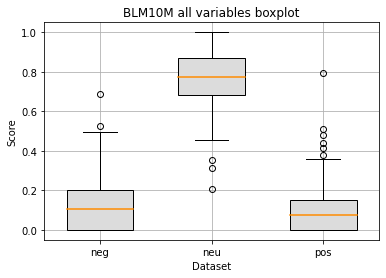

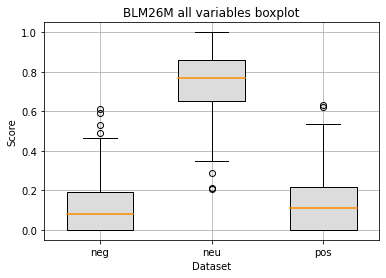

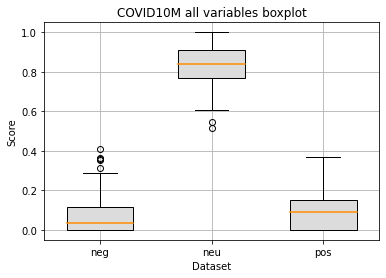

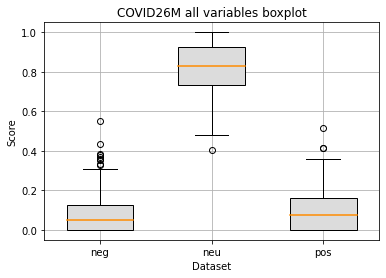

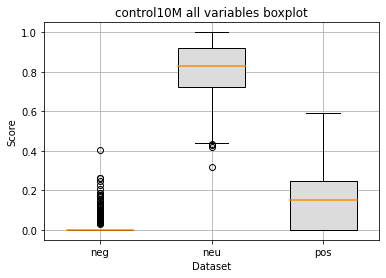

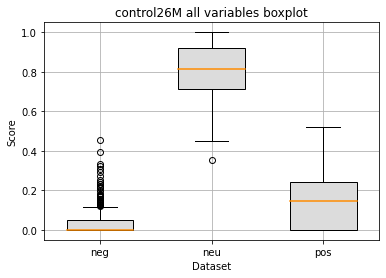

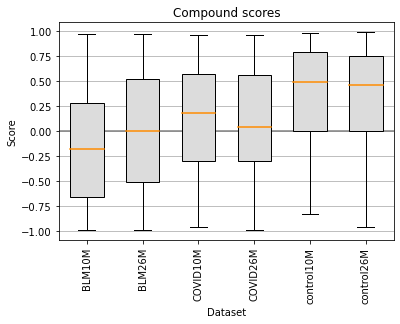

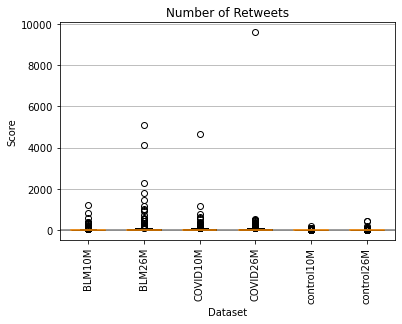

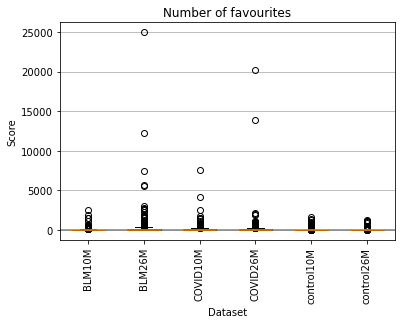

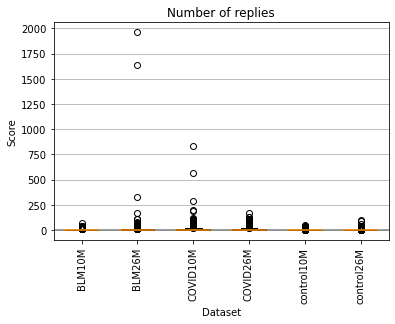

In [12]:
#DATA INSPECTION

save_comp = []
save_rts = []
save_fav = []
save_rep = []
save_pos = []
save_neu = []
save_neg = []

# Plot boxplots for each dataset (variables: neg, neu, pos)
for data in sampled_data:   
    plt.figure()
    sampled_data[data].boxplot(column=['neg', 'neu', 'pos'], 
                               widths= 0.6,
                               patch_artist=True, 
                               medianprops=dict(color='darkorange',linewidth=1.5),
                               whiskerprops= dict(color='k'),
                               boxprops=dict(facecolor='gainsboro', color='k'))
    plt.title(data + ' all variables boxplot')
    plt.xlabel('Dataset')
    plt.ylabel('Score')
    plt.show()

    # Save individual variables for plotting
    save_comp.append(sampled_data[data]['compound'])
    save_rts.append(sampled_data[data]['rts'])
    save_fav.append(sampled_data[data]['fav'])
    save_rep.append(sampled_data[data]['reply'])
    save_pos.append(sampled_data[data]['pos'])
    save_neu.append(sampled_data[data]['neu'])
    save_neg.append(sampled_data[data]['neg'])
    
# Plot boxplot for the compound score of each dataset
title= 'Compound scores'
label= sampled_data.keys()
variable_boxplot(save_comp, title, label)

# Plot RTs  
title= 'Number of Retweets'
variable_boxplot(save_rts, title, label)

# Plot Favs  
title= 'Number of favourites'
variable_boxplot(save_fav, title, label)

# Plot Reply  
title= 'Number of replies'
variable_boxplot(save_rep, title, label)


## 11. Exploratory 3D plot for all samples 
This code allows to explore the distribution of the samples in the "sentiment score" 3D space. For this plot the positive, neutral and negative variables are used to create a scatter plot of all the samples.

In [13]:
# %% 3D plot for all samples 
all_sampled = pd.DataFrame()
for data in sampled_data:
    sampled_data[data]['Dataset'] = [data] * len(sampled_data[data])

# Concatenate all samples and add a variable reflecting the class
all_sampled = pd.concat ([sampled_data['BLM10M'], sampled_data['BLM26M'], 
                          sampled_data['COVID10M'], sampled_data['COVID26M'],
                          sampled_data['control10M'], sampled_data['control26M']])

# 3D scatter plot all samles
fig = px.scatter_3d(all_sampled, x='neu', y='pos', 
                    z='neg', color='Dataset', 
                    opacity=0.7, title='Sample space (all datasets)')
fig.show()

## 12. One-class SVM for outlier identification
One-class SVM is an unsupervised machine learning algorithm aimed at outlier identification. The algorithm learns the limits of the sample space provided in the training phase and it is able to classify test samples as inliers or outliing samples. In this case, One-class SVM will be used to compare tweets from the same topic at different timempoints. By training in the reference timepoint (10M) and then testing with the data from after George Floyd's death (26M) it is possible to determine which are the tweets that are more different and to observe which trends do they follow (more negative, more positive...). 

One-class SVM as any support vector machine requires to define some parameters. The parameter `nu` determines the maximal proportion of missclassified samples, number of support vectors. The other parameters depend on the kernel used by the SVM:
- **Linear:** Does not require extra parameters. 
- **RBF:** Includes an extra parameter `gamma` which determines the radius of the kernel. It can be selected to be: <br>
 -* `'scale'`:  1 / (n_features * X.var()) <br>
 -* `'auto'`: 1 / (n_features)<br>
 In this case `'scale'` was selected. 

To identify the optimal nu value the function `one_class_parameters` was defined which tests the number of samples identified as outliers for a set of nu values in `nu_list`. 

Later, the One-class SVM analysis will be repeated using the right nu ('nu_selected') to identify the outlying tweets and visualise them in a 3D plot. This will be performed using the `one_class` function. 

For every class (BLM, COVID19 and control) the One-class SVM analysis will be repeated using a linear kernel and the RBF one. *For each kernel the optimal nu is identified independently.*
 

In [14]:
# %% FUNCTION DEFINITION: ONE CLASS outlier identification. 

def one_class_parameters(data_s, kernel, nu_list, gamma='scale'):
# Tests the number of outlying samples identified by when training the One-class SVM with different nu values. 
# INPUT: data_s= name of the class tested (BLM, COVID, control)
    # Define SVM parameters 
    num_out = [None] * len(nu_list) 

    for n, nus in enumerate(nu_list): #check param nu 
        
        if (kernel == 'rbf'):
            svm = OneClassSVM(kernel=kernel, nu=nus, gamma=gamma)
        else:
            svm = OneClassSVM(kernel=kernel, nu=nus)

        # Define training and test data 
        train_data = sampled_data[data_s + '10M'][['neg', 'neu', 'pos', 'compound']]
        test_data = sampled_data[data_s + '26M'][['neg', 'neu', 'pos', 'compound']]

        # Train algorithm
        BLM_svm = svm.fit(train_data)

        # Test algorithm
        pred = BLM_svm.predict(test_data)
        anom_index = np.where(pred == -1) # Class -1 = outlier 
        values = np.array(test_data)[anom_index] # Identify outlying samples
        df_values = pd.DataFrame(values, columns=['neg', 'neu', 'pos', 'compound'])

        # Identify which sample IDs have been marked as outliers
        ids = [None] * len(values) 
        for v, _ in enumerate(values):
            ids[v] = test_data.loc[(test_data['neg'] == df_values['neg'][v]) 
                                    & (test_data['neu'] == df_values['neu'][v])
                                    & (test_data['pos'] == df_values['pos'][v])
                                    & (test_data['compound'] == df_values['compound'][v])].index.values[0]
        num_out[n] = len(ids) # Count outliers

    # Histogram outliers
    plt.bar(np.arange(len(nu_list)), num_out)
    plt.xticks(np.arange(len(nu_list)), nu_list, rotation=90)
    plt.ylabel('Number of outliers')
    plt.xlabel('Value of parameter nu')
    plt.title(kernel + ': Num outliers depending on nu ' + data_s)
    plt.show()

def one_class (data_s, kernel, nu_selected, gamma='scale'):
    num_out = [] 
    if (kernel == 'rbf'):
        svm = OneClassSVM(kernel=kernel, nu=nu_selected, gamma=gamma)
    else:
        svm = OneClassSVM(kernel=kernel, nu=nu_selected)
   
    print(svm)
    # define training and test data 
    train_data = sampled_data[data_s + '10M'][['neg', 'neu', 'pos', 'compound']]
    test_data = sampled_data[data_s + '26M'][['neg', 'neu', 'pos', 'compound']]

    # Train algorithm
    BLM_svm = svm.fit(train_data)
    # Test algorithm
    pred = BLM_svm.predict(test_data)
    anom_index = np.where(pred == -1) # class -1 = outlier 
    values = np.array(test_data)[anom_index] #identify outlier samples
    df_values = pd.DataFrame(values, columns=['neg', 'neu', 'pos', 'compound'])

    # identify which sample ID has been marked as outlier
    ids = [None] * len(values) 
    for v, _ in enumerate(values):
        ids[v] = test_data.loc[(test_data['neg'] == df_values['neg'][v]) 
                                & (test_data['neu'] == df_values['neu'][v])
                                & (test_data['pos'] == df_values['pos'][v])
                                & (test_data['compound'] == df_values['compound'][v])].index.values[0]
    num_out= len(ids)

    #prepare data for 3D plot 
    test_data ['out'] = [0]*len(test_data) #class label
    test_data.loc[ids, 'out'] = 1 # outlier label 

    fig = px.scatter_3d(test_data, x='neu', y='pos', z='neg',
                        color='out', opacity=0.7, 
                     title=data_s + ' one-class ('
                            + kernel + ': ' 
                            + gamma + ')' 
                            + ' nu: ' + str(nu_selected))
    fig.show() 

    extracted_data = sampled_data[data_s + '26M'].loc[ids]
    # Print results: 
    print('The number of discrepant samples are: ' + str(num_out))
    print(extracted_data[['Text','compound']])

# Display full-size dataframe 
pd.set_option('display.max_colwidth', -1) 


### One-class SVM for BLM data

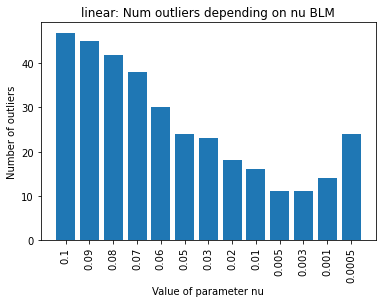

OneClassSVM(kernel='linear', nu=0.005)


The number of discrepant samples are: 11
                                                                                                                                                                                                                                                                                          Text  \
8849  NO JUSTICE NO PEACE #atlantaprotest #JusticeForGeorge #blacklivesmatter                                                                                                                                                                                                                    
1648  So emotional being a part of this today everyone was so peaceful and united. Please try to have a little empathy because we really have no idea what it’s like to live in fear everyday especially from the ones who are supposed to protect us #pittsburghprotest #BlackLivesMatter       
8769  white privilege is real. white privilege is real. white privilege is real. white pr

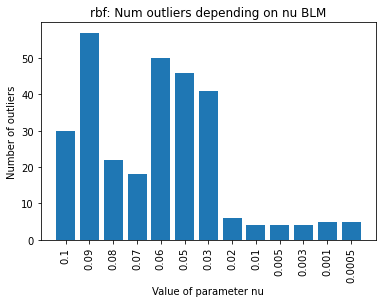

OneClassSVM(nu=0.002)


The number of discrepant samples are: 4
                                                                                                                                                                                                                                                                                          Text  \
8849  NO JUSTICE NO PEACE #atlantaprotest #JusticeForGeorge #blacklivesmatter                                                                                                                                                                                                                    
4388  We demand justice. No justice no peace #JusticeForGeorgeFlyod #BlackLivesMatter #BLACK_LIVES_MATTER                                                                                                                                                                                        
4186  No justice, no peace. #BlackLivesMatter                                             

In [15]:
# Linear kernel one_class: find optimal nu: 
data_s = 'BLM' 
kernel = 'linear' # linear or rbf
nu_list = [
            0.1, 0.09, 0.08, 0.07, 0.06, 
            0.05, 0.03, 0.02, 0.01, 0.005, 
            0.003, 0.001, 0.0005
          ]

one_class_parameters(data_s, kernel, nu_list)

# Linear kernel one_class tested with optimal nu

nu_selected = 0.005
one_class(data_s, kernel, nu_selected)

#RBF kernel one_class: find optimal nu: 
data_s = 'BLM'
kernel = 'rbf' 
gamma = 'scale' #auto or rbf
one_class_parameters(data_s, kernel, nu_list, gamma=gamma)

nu_selected = 0.002
one_class(data_s, kernel, nu_selected, gamma=gamma)

### One-class SVM for COVID data

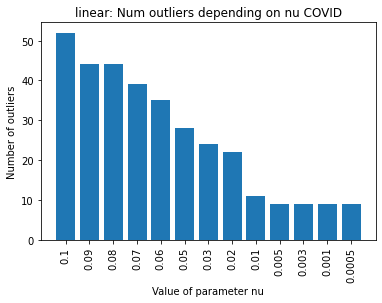

OneClassSVM(kernel='linear', nu=0.01)


The number of discrepant samples are: 11
                                                                                                                                                                                                                                                                                       Text  \
3728  So sad and tragic. A young promising doctor dies due to #Covid19. Unbearable grief for his family. Irreparable loss for his community.                                                                                                                                                  
8629  Let's fight back against #COVID19 &amp; #ClimateChange. We encourage developers &amp; innovators to make a difference. Join @CallforCode &amp; its partner @UNHumanRights to help create solutions for the world's most vulnerable people. Visit: http://CallforCode.org #TechForGood   
692   Treat others the way you want to be treated... #Ismaili #OneJamat #OneHumanity #COVID19 #Tog

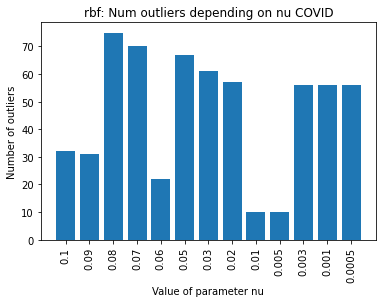

OneClassSVM(nu=0.01)


The number of discrepant samples are: 10
                                                                                                                                                                                                                                                                                                                                                                              Text  \
4488  People protesting #GeorgeFloyd murder chanting #icantbreathe ? Are risking their lives during #COVID19 This isn't MAGA folks with semi autos who think #COVID19 is a HOAX These are the most directly impacted by #COVID19 Risking a virus to fight the virus of US racism                                                                                                     
7566  11 fashion brands that are helping fight the #COVID19 pandemic                                                                                                                                               

In [16]:
# %% One-class COVID
data_s = 'COVID' # BLM, COVID, CONTROL
kernel = 'linear' # linear or rbf
one_class_parameters(data_s, kernel, nu_list)

# Linear kernel one_class tested with optimal nu

nu_selected = 0.01
one_class(data_s, kernel, nu_selected)

#RBF kernel one_class: find optimal nu: 
data_s = 'COVID'
kernel = 'rbf' 
gamma = 'scale' #auto or rbf
one_class_parameters(data_s, kernel, nu_list, gamma=gamma)

nu_selected = 0.01
one_class(data_s, kernel, nu_selected, gamma=gamma)

### One-class SVM for control data

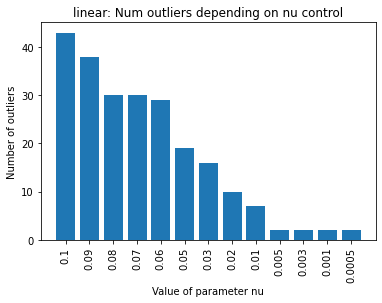

OneClassSVM(kernel='linear', nu=0.005)


The number of discrepant samples are: 2
                                                                                                                                   Text  \
k83   Poor darling #kitten at SAVE THE CATS #Wichita https://m.facebook.com/story.php?story_fbid=246918743390947&amp;id=103618084387681   
k116  Lazy morning #Kitten #Kitty                                                                                                         

      compound  
k83   0.6841    
k116 -0.3612    


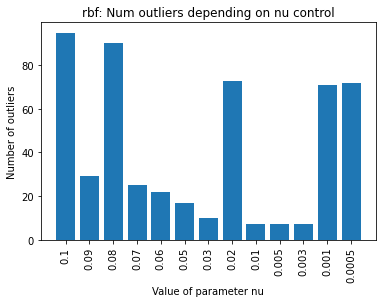

OneClassSVM(nu=0.01)


The number of discrepant samples are: 7
                                                                                                                                                                                                                                                                                         Text  \
k131  She wasn't here for months! My own personal devil. #cat #gingercat #ginger #kitten #devil #sleepy https://www.instagram.com/p/CApV3VnK8tQ/?igshid=1k1c0q12a42u9                                                                                                                           
k83   Poor darling #kitten at SAVE THE CATS #Wichita https://m.facebook.com/story.php?story_fbid=246918743390947&amp;id=103618084387681                                                                                                                                                         
217   Hershes #adopt #pet #StAugustine https://wwpetrescue.org/pet/hershes/                  

In [17]:
# %% One-class control
data_s = 'control' # BLM, COVID, control
kernel = 'linear' # linear or rbf
one_class_parameters(data_s, kernel, nu_list)

# Linear kernel one_class tested with optimal nu

nu_selected = 0.005
one_class(data_s, kernel, nu_selected)

#RBF kernel one_class: find optimal nu: 
data_s = 'control'
kernel = 'rbf' 
gamma = 'scale' #auto or scale
one_class_parameters(data_s, kernel, nu_list, gamma=gamma)

nu_selected = 0.01
one_class(data_s, kernel, nu_selected, gamma=gamma)